<a href="https://colab.research.google.com/github/Murcha1990/Otkritie_intensiv/blob/main/ML_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи поиска оттоковых клиентов

* Загрузка данных и их анализ
* Обучение и оценка качества модели
  + обучение модели
  + оценка качества модели
* Интерпретация результатов модели
* Сохранение результатов

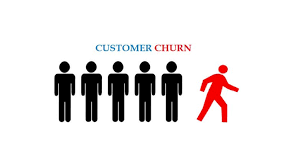

Мы будем пользоваться следующими библиотеками Python:

*   Pandas - библиотеки для работы с таблицами
*   Numpy - библиотеки для быстрых и эффективных вычислений
*   Matplotlib - для визуализации данных
*   Sklearn - библиотеки с основными инструментами ML

С функционалом этих библиотек разберемся в процессе прохождения курса.

Будем решать задачу определения оттоковых клиентов,  а именно, *по характеристикам клиентов некоторого банка будем определять, собираются ли клиенты сменить оператора мобильной связи или нет*.

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

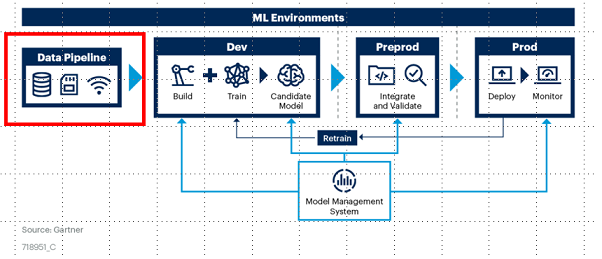

In [93]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

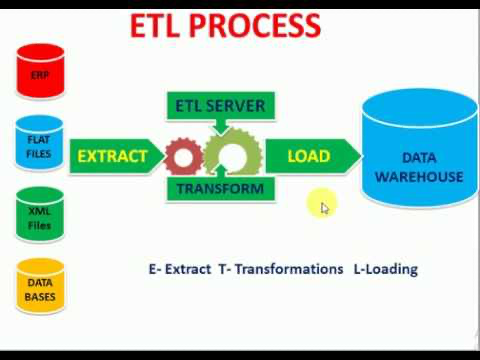

In [94]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-03-04 07:03:09--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-03-04 07:03:10 (514 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [95]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:14 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRe

In [96]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [97]:
import pandas as pd

query = "SELECT * from public.clients"
data = pd.read_sql_query(query, conn)

conn.close()

Посмотрим на данные.

Описание данных клиентов:
* state, string. 2-letter code of the US state of customer residence
* account_length, numerical. Number of months the customer has been with the current telco provider
* area_code, string="area_code_AAA" where AAA = 3 digit area code.
* international_plan, (yes/no). The customer has international plan.
* voice_mail_plan, (yes/no). The customer has voice mail plan.
* number_vmail_messages, numerical. Number of voice-mail messages.
* total_day_minutes, numerical. Total minutes of day calls.
* total_day_calls, numerical. Total number of day calls.
* total_day_charge, numerical. Total charge of day calls.
* total_eve_minutes, numerical. Total minutes of evening calls.
* total_eve_calls, numerical. Total number of evening calls.
* total_eve_charge, numerical. Total charge of evening calls.
* total_night_minutes, numerical. Total minutes of night calls.
* total_night_calls, numerical. Total number of night calls.
* total_night_charge, numerical. Total charge of night calls.
* total_intl_minutes, numerical. Total minutes of international calls.
* total_intl_calls, numerical. Total number of international calls.
* total_intl_charge, numerical. Total charge of international calls
* number_customer_service_calls, numerical. Number of calls to customer service
* churn, (yes/no). Customer churn - target variable.




In [98]:
data.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,KS,128,415,No,Yes,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,False


## <font color='green'> 2. Разведочный анализ данных</font>

## 1. Оценка качества данных
* пропущенные значения
* ошибочные значения

In [99]:
len(data)

3333

Посмотрим, есть ли в данных пропущенные значения.

In [100]:
data.isna().sum()

state                   0
accountlength           0
areacode                0
internationalplan       0
voicemailplan           0
numbervmailmessages     0
totaldayminutes         0
totaldaycalls           0
totaldaycharge          0
totaleveminutes         0
totalevecalls           0
totalevecharge          0
totalnightminutes       0
totalnightcalls         0
totalnightcharge        0
totalintlminutes        0
totalintlcalls          0
totalintlcharge         0
customerservicecalls    0
churn                   0
dtype: int64

### Обработка пропущенных значений

Пропусков в данных нет. А что делать, если бы были?

Немного испортим данные.

In [101]:
import numpy as np

data.at[np.random.choice(len(data),50), 'areacode'] = np.nan
data.at[np.random.choice(len(data),10), 'totaldayminutes'] = np.nan
data.at[np.random.choice(len(data),5), 'totaleveminutes'] = np.nan
data.at[np.random.choice(len(data),20), 'voicemailplan'] = "Nou"

In [102]:
data.isna().sum()

state                    0
accountlength            0
areacode                50
internationalplan        0
voicemailplan            0
numbervmailmessages      0
totaldayminutes         10
totaldaycalls            0
totaldaycharge           0
totaleveminutes          5
totalevecalls            0
totalevecharge           0
totalnightminutes        0
totalnightcalls          0
totalnightcharge         0
totalintlminutes         0
totalintlcalls           0
totalintlcharge          0
customerservicecalls     0
churn                    0
dtype: int64

Areacode - **категориальный признак** (это код области, не число по сути). Обычно пропуски в таких признаках заполняют некоторой уникальной категорией.

In [103]:
data['areacode']

0       415.0
1       415.0
2       415.0
3       408.0
4       415.0
        ...  
3328    415.0
3329    415.0
3330    510.0
3331    510.0
3332    415.0
Name: areacode, Length: 3333, dtype: float64

In [104]:
data.areacode.value_counts()

415.0    1628
510.0     829
408.0     826
Name: areacode, dtype: int64

In [105]:
data['areacode'] = data['areacode'].fillna(-100)

In [106]:
data.areacode.value_counts()

 415.0    1628
 510.0     829
 408.0     826
-100.0      50
Name: areacode, dtype: int64

Totaldayminutes - **числовой признак**. Пропуски в числовых признаках обычно заполняют средним значением или медианой.

In [107]:
median = data['totaldayminutes'].median()

data['totaldayminutes'].fillna(median, inplace=True)

In [108]:
print(median)

179.4


In [109]:
data.isna().sum()

state                   0
accountlength           0
areacode                0
internationalplan       0
voicemailplan           0
numbervmailmessages     0
totaldayminutes         0
totaldaycalls           0
totaldaycharge          0
totaleveminutes         5
totalevecalls           0
totalevecharge          0
totalnightminutes       0
totalnightcalls         0
totalnightcharge        0
totalintlminutes        0
totalintlcalls          0
totalintlcharge         0
customerservicecalls    0
churn                   0
dtype: int64

Заполним пропуски в столбце totaleveminutes медианным значением.

In [110]:
median = data['totaleveminutes'].median()
print(median)

data['totaleveminutes'].fillna(median, inplace=True)

201.4


## Ошибочные значения

Выведите на экран число различных значений в столбце voicemailplan, используя value_counts

In [111]:
data['voicemailplan'].value_counts()

No     2393
Yes     920
Nou      20
Name: voicemailplan, dtype: int64

In [112]:
data['voicemailplan'] = data['voicemailplan'].replace('Nou', 'No')

In [113]:
data['voicemailplan'].value_counts()

No     2413
Yes     920
Name: voicemailplan, dtype: int64

## Основные числовые характеристики

In [114]:
data['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [115]:
data.describe()

,accountlength,areacode,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,429.168317,8.099010,179.748065,100.435644,30.562307,200.981218,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,77.696385,13.688365,54.413535,20.069084,9.259435,50.698549,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,415.000000,20.000000,216.200000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [116]:
data.describe(include='object') # категориальные колонки

,state,internationalplan,voicemailplan
count,3333,3333,3333
unique,51,2,2
top,WV,No,No
freq,106,3010,2413


In [117]:
corr = data.corr() # строим матрицу корреляций

corr.style.background_gradient(cmap='coolwarm')

,accountlength,areacode,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
accountlength,1.000000,0.000766,-0.004628,0.004448,0.038470,0.006214,-0.006518,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
areacode,0.000766,1.000000,0.013448,-0.000397,0.011524,0.001429,-0.011307,0.007465,-0.011167,-0.002070,0.011109,-0.002099,0.022315,-0.012342,0.022400,0.003847,-0.031557
numbervmailmessages,-0.004628,0.013448,1.000000,0.001354,-0.009548,0.000776,0.017522,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
totaldayminutes,0.004448,-0.000397,0.001354,1.000000,0.006249,0.999008,0.007480,0.014499,0.006548,0.004431,0.022150,0.004410,-0.010115,0.008864,-0.010052,-0.013419,0.204739
totaldaycalls,0.038470,0.011524,-0.009548,0.006249,1.000000,0.006753,-0.021641,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
totaldaycharge,0.006214,0.001429,0.000776,0.999008,0.006753,1.000000,0.007968,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
totaleveminutes,-0.006518,-0.011307,0.017522,0.007480,-0.021641,0.007968,1.000000,-0.011468,0.999698,-0.012760,0.006727,-0.012769,-0.011203,0.003136,-0.011234,-0.012481,0.092817
totalevecalls,0.019260,0.007465,-0.005864,0.014499,0.006462,0.015769,-0.011468,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233
totalevecharge,-0.006745,-0.011167,0.017578,0.006548,-0.021449,0.007036,0.999698,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987,0.092786
totalnightminutes,-0.008955,-0.002070,0.007681,0.004431,0.022938,0.004324,-0.012760,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288,0.035493


In [118]:
data = data.drop(['totaldaycharge','totalnightcharge','totalintlcharge','totalevecharge'],axis=1)

## <font color='green'>3. Обучение модели</font>



## <font color='green'>3.1. Построение базовой модели</font>



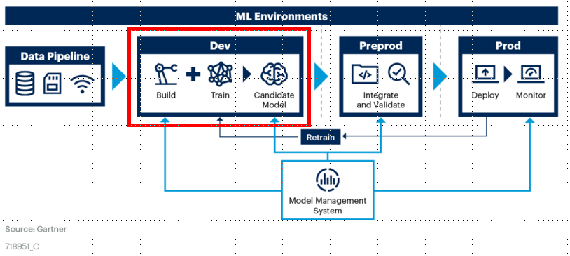

Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [119]:
X = data.drop('churn', axis=1) # матрица объект-признак
y = data['churn'] # целевая переменная

Пока что выкинем нечисловые признаки.

In [120]:
X_full = X.copy()
X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)

Разобъем данные на тренировочную и тестовую части.

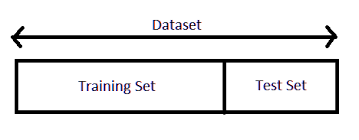

In [121]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Масштабируем данные.

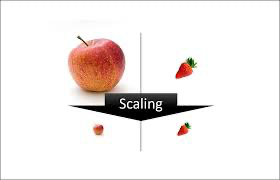

In [122]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,accountlength,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,customerservicecalls
0,-1.404508,-0.584700,-1.885207,1.330852,1.038123,0.401340,1.069609,0.004940,2.768109,-0.595235,-0.427903
1,0.366388,-0.584700,0.294177,0.529165,0.516363,0.401340,2.214376,0.670832,1.051970,-1.417963,0.324616
2,0.518179,1.685101,1.057054,-1.875896,0.093422,0.849774,-0.077125,-0.763398,-0.056369,0.227493,1.829653
3,2.010792,-0.584700,-0.679787,1.681590,-0.402645,0.650470,-0.322994,-0.660953,-0.056369,-0.183871,-0.427903
4,0.290493,-0.584700,0.484896,1.080325,-0.718863,-0.296224,-1.186487,0.056162,0.837453,1.050221,1.077134


## Логистическая регрессия

Когда мы решаем задачу классификации, мы можем захотеть предсказывать не только классы, но и их вероятности. Для целей бизнеса, например, полезно знать, с какой вероятностью клиент вернет кредит (а не просто - вернет кредит или не вернет). Например, если клиент уйдет из банка с вероятностью 0.95, то это очень ненадежный клиент. А если с вероятностью 0.52  - этот клиент под вопросом. Но с точки зрения бинарной классификации для обоих клиентов модель предскажет, что они уйдут, так как стандартный порог перевода вероятности в классы - 0.5. 

* задача классификации, в которой модель предсказывает только классы - это **жесткая классификация**
* если же классификатор предсказывает вероятности классов - это **мягкая классификация**

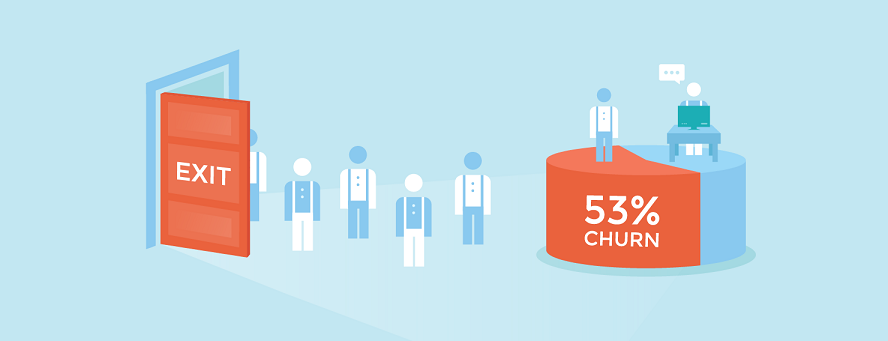

**Логистическая регрессия** - это линейный классификатор, который кроме классов умеет предсказывать вероятности классов.

Модель делает предсказания по формуле
$$a(x) = \sigma(w_0 + w_1x_1 + w_2x_2 + ...),$$
то есть умножает признаки объекта $x_1,x_2,...$ на некоторые веса $w_0,w_1,w_2,...$

Например, если 
* $x_1$ - возраст клиента
* $x_2$ - число жалоб клиента на банк, 
то обученная модель может иметь вид
$$a(x) = \sigma(10 - 3x_1 + 50x_2)$$

Веса модели подбираются автоматически так, чтобы ошибка предсказания модели была минимальной.

Функция $\sigma(x)$ - переводит предсказания модели в вероятности:

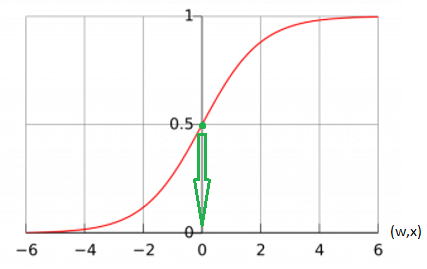

Давайте применим логистическую регрессию для поиска оттоковых клиентов!

In [123]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # объявление модели
model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [124]:
pred_classes = model.predict(Xtest) # предсказание классов

In [125]:
accuracy_score(ytest, pred_classes)

0.854916067146283

In [126]:
pred_scores = model.predict_proba(Xtest)[:,1] # предсказание вероятностей классов

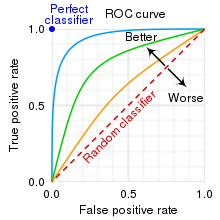

In [127]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ytest, pred_scores)

0.7884005641748941

## <font color='green'>2.2. Валидация модели</font>

Для оценки качества моделей бинарной классификации полезно смотреть на матрицу ошибок.

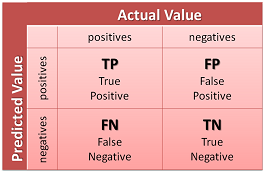

In [128]:
from sklearn.metrics import confusion_matrix, recall_score

classes = pred_scores > 0.2

confusion_matrix(ytest, classes)

array([[587, 122],
       [ 46,  79]])

In [129]:
recall_score(ytest, classes)

0.632

## Метод ближайших соседей

Существует еще один простой метод для решения задач классификации - метод ближайших соседей.

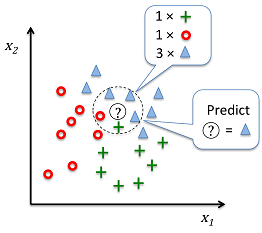

Попробуем применить метод ближайших соседей для решения поставленной задачи.

In [130]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [131]:
knn.fit(Xtrain, ytrain)

pred_test2 = knn.predict_proba(Xtest)[:,1]

classes2 = pred_test2 > 0.1

confusion_matrix(ytest, classes2)

array([[463, 246],
       [ 28,  97]])

## <font color='green'>3. Улучшение качества моделей и их интерпретация </font>

Выше мы удаляли все категориальные столбцы:

`X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)`

А вдруг там содержится много полезной информации? Попробуем её сохранить.

In [132]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [133]:
Xtrain.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,customerservicecalls
367,MD,45,415.0,No,No,0,78.2,127.0,253.4,108.0,255.0,100.0,18.0,3.0,1
3103,DE,115,415.0,No,No,0,195.9,111.0,227.0,108.0,313.2,113.0,13.2,1.0,2
549,OK,121,408.0,No,Yes,31,237.1,63.0,205.6,117.0,196.7,85.0,10.1,5.0,4
2531,RI,180,415.0,No,No,0,143.3,134.0,180.5,113.0,184.2,87.0,10.1,4.0,1
2378,OR,112,510.0,No,No,0,206.2,122.0,164.5,94.0,140.3,101.0,12.6,7.0,3


Закодируем при помощи OneHot-encoding категориальные столбцы.

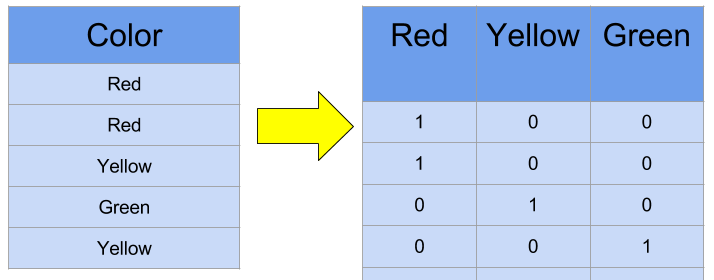

In [134]:
from sklearn.preprocessing import OneHotEncoder

categorical = ['state','areacode','voicemailplan','internationalplan']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_encoder.fit(Xtrain[categorical])

Xtrain_ohe = pd.DataFrame(OH_encoder.fit_transform(Xtrain[categorical]), columns=OH_encoder.get_feature_names_out())
Xtest_ohe = pd.DataFrame(OH_encoder.transform(Xtest[categorical]), columns=OH_encoder.get_feature_names_out())

In [135]:
Xtrain_ohe.head()

,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,...,state_WV,state_WY,areacode_-100.0,areacode_408.0,areacode_415.0,areacode_510.0,voicemailplan_No,voicemailplan_Yes,internationalplan_No,internationalplan_Yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


Масштабируем числовые столбцы.

In [136]:
numeric = [col for col in Xtrain.columns if col not in categorical]
numeric

['accountlength',
 'numbervmailmessages',
 'totaldayminutes',
 'totaldaycalls',
 'totaleveminutes',
 'totalevecalls',
 'totalnightminutes',
 'totalnightcalls',
 'totalintlminutes',
 'totalintlcalls',
 'customerservicecalls']

In [137]:
from sklearn.preprocessing import MinMaxScaler

Xtrain_num = Xtrain[numeric]
Xtest_num = Xtest[numeric]

scaler = MinMaxScaler()
scaler.fit(Xtrain_num)

Xtrain_num = pd.DataFrame(scaler.transform(Xtrain_num), columns=Xtrain_num.columns)
Xtest_num = pd.DataFrame(scaler.transform(Xtest_num), columns=Xtest_num.columns)

Собираем итоговые матрицы признаков.

In [138]:
Xtrain_good = pd.concat([Xtrain_num, Xtrain_ohe], axis=1)
Xtest_good = pd.concat([Xtest_num, Xtest_ohe], axis=1)

In [139]:
Xtrain_good.head()

,accountlength,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,...,state_WV,state_WY,areacode_-100.0,areacode_408.0,areacode_415.0,areacode_510.0,voicemailplan_No,voicemailplan_Yes,internationalplan_No,internationalplan_Yes
0,0.190476,0.000000,0.217117,0.718519,0.696728,0.635294,0.623453,0.471831,0.900,0.166667,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.493506,0.000000,0.555141,0.600000,0.624141,0.635294,0.779989,0.563380,0.660,0.055556,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.519481,0.607843,0.673464,0.244444,0.565301,0.688235,0.466649,0.366197,0.505,0.277778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.774892,0.000000,0.404078,0.770370,0.496288,0.664706,0.433029,0.380282,0.505,0.222222,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.480519,0.000000,0.584721,0.681481,0.452296,0.552941,0.314954,0.478873,0.630,0.388889,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### <font color='green'>3.1. Логистическая регрессия на всех признаках </font>

In [140]:
model = LogisticRegression()
model.fit(Xtrain_good, ytrain) 

probs = model.predict_proba(Xtest_good)[:,1]

In [141]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ytest, probs)

0.8272045133991538

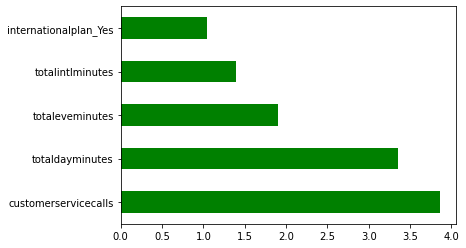

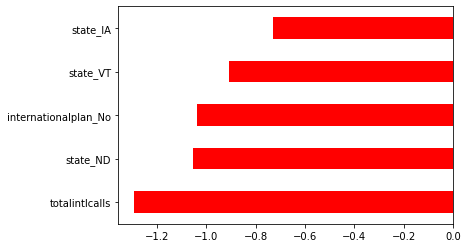

In [142]:
pd.Series(model.coef_[0], index=Xtrain_good.columns).nlargest(5).plot(kind='barh',color='green')
plt.show()
pd.Series(model.coef_[0], index=Xtrain_good.columns).nsmallest(5).plot(kind='barh',color='red')
plt.show()

### <font color='green'>3.2. CatBoost на всех признаках </font>

In [143]:
!pip install catboost -q

In [144]:
from catboost import CatBoostClassifier

gbm = CatBoostClassifier(iterations=300, #сколько деревьев
                          depth=2, #глубина каждого дерева
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(Xtrain_good, ytrain)
gbm_preds = gbm.predict_proba(Xtest_good)[:,1]

In [145]:
roc_auc_score(ytest, gbm_preds)

0.9319153737658674

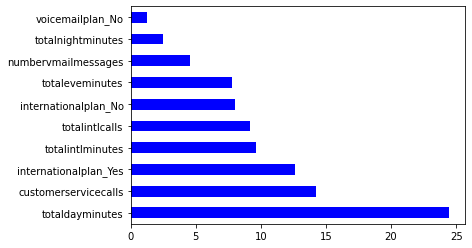

In [146]:
pd.Series(gbm.feature_importances_, index=Xtrain_good.columns).nlargest(10).plot(kind='barh',color='blue')
plt.show()

## <font color='green'>4. Получение предсказаний на новых данных. </font>


Вручную добавим данные о новом клиенте.

In [155]:
NewData = pd.DataFrame(columns=Xtrain.columns)
NewData = NewData.append({'state' : 'CO', 
                'accountlength' : 71,
                'areacode' : 415,
                'internationalplan' : 'No',
                'voicemailplan' : 'No',
                'numbervmailmessages': 0,
                'totaldayminutes' : 30, 
                'totaldaycalls' : 70.0,
                'totaleveminutes' : 252.7,
                'totalevecalls' : 122.0,
                'totalnightminutes' : 225.8,
                'totalnightcalls' : 104.0,
                'totalintlminutes' : 12.3,
                'totalintlcalls' : 3.0,
                'customerservicecalls' : 10 
}, ignore_index=True)

NewData.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,customerservicecalls
0,CO,71,415,No,No,0,30,70.0,252.7,122.0,225.8,104.0,12.3,3.0,10


Обработаем данные так же, как делали это при обучении модели.

In [157]:
NewData_ohe = pd.DataFrame(OH_encoder.transform(NewData[categorical]), columns=OH_encoder.get_feature_names_out())
NewData_num = pd.DataFrame(scaler.transform(NewData[numeric]), columns=NewData[numeric].columns)

NewData = pd.concat([NewData_num, NewData_ohe], axis=1)

Делаем предсказание при помощи бустинга.

In [150]:
gbm_preds = gbm.predict_proba(NewData)[:,1]

gbm_preds

array([0.06062801])

Согласно модели, этот клиент скорее всего не покинет компанию? А почему?

* Попробуем увеличить число звонков в службу поддержки (поставим 10).

In [154]:
gbm_preds = gbm.predict_proba(NewData)[:,1]

gbm_preds

array([0.34309988])

* А еще уменьшим `totaldayminutes` до 30.

In [158]:
gbm_preds = gbm.predict_proba(NewData)[:,1]

gbm_preds

array([0.96409059])

## Как еще улучшить качество? Подбор гиперпараметров

In [163]:
from sklearn.model_selection import GridSearchCV

gbm2 = CatBoostClassifier(iterations=300,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)

params = {'max_depth': [2, 3, 4, 5, 6]}

gs = GridSearchCV(gbm2, params, cv=3, scoring='roc_auc')

gs.fit(Xtrain_good, ytrain)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f7d9cf22670>,
             param_grid={'max_depth': [2, 3, 4, 5, 6]}, scoring='roc_auc')

In [164]:
gs.best_estimator_, gs.best_score_, gs.best_params_

(<catboost.core.CatBoostClassifier at 0x7f7d9cc76b20>,
 0.9089638071767495,
 {'max_depth': 6})

In [165]:
pred_gbm = gs.best_estimator_.predict_proba(Xtest_good)[:,1]

In [166]:
roc_auc_score(ytest, pred_gbm)

0.9320733427362482